In [1]:
# Imports
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import gc
from IPython.display import display

# Sci-kit Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# NN
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Conv2D, MaxPooling2D

In [2]:
# Load file
df = pd.read_csv("all_merged_sw.csv",
                 usecols=['post_id', 'date', 'sw_18_num_comments', 'sw_18_score', 'sw_18_total_awards',
                          'author_commentkarma', 'sw_18_compound_score', 'trustworthy', 'sw_18_author_trust',
                          'author_trust', 'author_id', 'author_name',
                          'ticker', 'post_type', 'adjclose_20_X', 'adjclose_19_X', 'adjclose_18_X',
                          'adjclose_17_X', 'adjclose_16_X', 'adjclose_15_X', 'adjclose_14_X', 
                          'adjclose_13_X', 'adjclose_12_X', 'adjclose_11_X', 'adjclose_10_X',
                          'adjclose_9_X', 'adjclose_8_X', 'adjclose_7_X', 'adjclose_6_X',
                          'adjclose_5_X', 'adjclose_4_X', 'adjclose_3_X', 'adjclose_2_X',
                          'adjclose_1_X', 'adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                          'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y',
                          'adjclose_9_Y', 'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y',
                          'adjclose_13_Y', 'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                          'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y',
                          'adjclose_21_Y'])

# Apply trust filter
df = df[(df["sw_18_author_trust"] >= 0.8) & (df["trustworthy"] == 1)]

df

,post_id,date,author_commentkarma,author_id,author_name,ticker,post_type,adjclose_20_X,adjclose_19_X,adjclose_18_X,...,adjclose_19_Y,adjclose_20_Y,adjclose_21_Y,trustworthy,author_trust,sw_18_num_comments,sw_18_score,sw_18_total_awards,sw_18_compound_score,sw_18_author_trust
92,ed2x6fn,2019-01-02,712.0,rw1ynq0,martimook,CPSI,comment,25.979984,25.950769,25.882610,...,25.366512,25.347040,25.551525,1,0.800000,2.0,61.0,0.0,0.05160,0.800000
1144,ed7nipz,2019-01-04,3.0,4jd5aav,fz27fz,BPY,comment,14.357750,14.423088,14.292412,...,14.864111,14.864111,15.166289,1,1.000000,0.0,-1.0,0.0,0.44040,1.000000
1238,edbgm1u,2019-01-05,7053.0,16ggvx,oheggroll,CPST,comment,7.100000,7.000000,7.200000,...,8.900000,9.200000,9.000000,1,0.608696,1.0,6.0,0.0,0.00425,0.804348
1327,edanxb1,2019-01-05,254.0,302u3wv,dafquaf,CPST,comment,7.100000,7.000000,7.200000,...,8.900000,9.200000,9.000000,1,1.000000,1.0,6.0,0.0,0.00425,0.804348
1475,edeky6t,2019-01-06,823.0,3biya2u,4MyPeers,CBAT,comment,0.550000,0.540000,0.570000,...,1.190000,1.120000,1.150000,1,1.000000,0.0,1.0,0.0,-0.07720,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929283,gh9pob6,2020-12-28,646.0,686eo6a9,nefar1ousdeath,IDXG,comment,3.030000,3.020000,3.050000,...,4.300000,4.430000,4.170000,1,1.000000,0.0,1.0,0.0,0.12800,1.000000
936689,ghgeynu,2020-12-30,1055.0,8ibinict,SnooCaperz,WHF,comment,13.137235,13.381059,13.381059,...,13.660000,13.520000,13.550000,1,1.000000,0.0,2.0,0.0,0.27320,1.000000
939869,ghms232,2020-12-31,66817.0,5dmrn99z,Experienced_AP,PBPB,comment,4.720000,4.700000,4.660000,...,4.880000,5.390000,5.430000,1,1.000000,0.0,1.0,0.0,0.10270,1.000000
939989,ghkio9m,2020-12-31,75.0,8nh43gr6,Jelly_Sir,ANAB,comment,25.790001,25.790001,24.680000,...,24.230000,25.920000,25.940001,1,1.000000,0.0,1.0,0.0,0.44040,1.000000


In [3]:
# Print the colum names
df.columns.values

array(['post_id', 'date', 'author_commentkarma', 'author_id',
       'author_name', 'ticker', 'post_type', 'adjclose_20_X',
       'adjclose_19_X', 'adjclose_18_X', 'adjclose_17_X', 'adjclose_16_X',
       'adjclose_15_X', 'adjclose_14_X', 'adjclose_13_X', 'adjclose_12_X',
       'adjclose_11_X', 'adjclose_10_X', 'adjclose_9_X', 'adjclose_8_X',
       'adjclose_7_X', 'adjclose_6_X', 'adjclose_5_X', 'adjclose_4_X',
       'adjclose_3_X', 'adjclose_2_X', 'adjclose_1_X', 'adjclose_2_Y',
       'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y', 'adjclose_6_Y',
       'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
       'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y', 'adjclose_14_Y',
       'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y', 'adjclose_18_Y',
       'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y', 'trustworthy',
       'author_trust', 'sw_18_num_comments', 'sw_18_score',
       'sw_18_total_awards', 'sw_18_compound_score', 'sw_18_author_trust'],
      dty

In [4]:
# Find the min and max at 1-4 business week intervals
df['5day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y']].idxmin(axis=1)

df['10day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y']].idxmin(axis=1)

df['15day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y']].idxmin(axis=1)

df['20day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                      'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y',
                      'adjclose_20_Y', 'adjclose_21_Y']].idxmin(axis=1)

df['5day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y']].idxmax(axis=1)

df['10day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y']].idxmax(axis=1)

df['15day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y']].idxmax(axis=1)

df['20day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                      'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y',
                      'adjclose_20_Y', 'adjclose_21_Y']].idxmax(axis=1)

# Extract the day number and convert to int
df['5day_min'] = df['5day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['10day_min'] = df['10day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['15day_min'] = df['15day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['20day_min'] = df['20day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['5day_max'] = df['5day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['10day_max'] = df['10day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['15day_max'] = df['15day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['20day_max'] = df['20day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)

In [5]:
# Get the X-variable columns
df_X = df[['sw_18_num_comments', 'sw_18_score', 'sw_18_total_awards', 'author_commentkarma',
           'sw_18_compound_score', 'adjclose_20_X', 'adjclose_19_X', 'adjclose_18_X',
           'adjclose_17_X', 'adjclose_16_X', 'adjclose_15_X', 'adjclose_14_X',
           'adjclose_13_X', 'adjclose_12_X', 'adjclose_11_X', 'adjclose_10_X',
           'adjclose_9_X', 'adjclose_8_X', 'adjclose_7_X', 'adjclose_6_X',
           'adjclose_5_X', 'adjclose_4_X', 'adjclose_3_X', 'adjclose_2_X',
           'adjclose_1_X']].to_numpy()

# Get the Y-variable columns
df_Y = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y',
           'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y',
           'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
           'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y',
           'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y',
           '5day_min', '10day_min', '15day_min', '20day_min', '5day_max',
           '10day_max', '15day_max', '20day_max']].to_numpy()

# Clear up memory
del df
gc.collect()

# Get 80% of the data by date
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2,
                                                    shuffle=False)

# Print
print(X_train)
print(X_test)
print(y_train)
print(y_test)

[[ 2.         61.          0.         ... 27.21815872 26.13175964
  26.09296036]
 [ 0.         -1.          0.         ... 15.19852448 15.01395988
  15.0219841 ]
 [ 1.          6.          0.         ...  8.30000019  8.5
   8.5       ]
 ...
 [ 0.          1.          0.         ...  6.15999985  6.11999989
   6.23000002]
 [ 2.          2.          0.         ... 17.35000038 17.71999931
  16.79999924]
 [ 0.          2.          0.         ... 99.94000244 98.86000061
  99.23999786]]
[[ 1.         34.          0.         ...  9.13000011  8.97000027
   9.43000031]
 [ 1.          6.          0.         ... 69.0973587  68.79788208
  70.13552094]
 [ 0.          1.          0.         ...  1.94000006  1.90999997
   1.89999998]
 ...
 [ 0.          1.          0.         ...  3.47000003  3.3499999
   3.43000007]
 [ 0.          1.          0.         ... 29.62999916 29.70000076
  30.        ]
 [ 0.          1.          0.         ... 24.92000008 23.57999992
  23.29000092]]
[[ 24.86989403  25.41520

In [6]:
# Normalize data
scaler = MinMaxScaler()

print(scaler.fit(X_train))
xtrain_scale=scaler.transform(X_train)

print(scaler.fit(X_test))
xval_scale=scaler.transform(X_test)

print(scaler.fit(y_train))
ytrain_scale=scaler.transform(y_train)

print(scaler.fit(y_test))
yval_scale=scaler.transform(y_test)

# Set input and output dimensions
indim = X_train.shape[1]
outdim = y_train.shape[1]

# Initialize Feed-Forward Neural Network
model = Sequential()

# Create NN structure
# Input layer
model.add(Dense(indim+1, input_dim=indim, activation="softmax"))

# Hidden layer with ~sqrt(X_train.shape[0] = sqrt(188157))
model.add(Dense(434, activation="softmax"))

# Output layer
model.add(Dense(outdim))

# Compile the model
model.compile(optimizer='rmsprop', loss='mse', metrics=['mse', 'mae'])

# Train
model.fit(xtrain_scale, ytrain_scale, epochs=10, batch_size=20, verbose=0)

# Predict
ypred = model.predict(xval_scale)

# Scale back to original scale
ypred = scaler.inverse_transform(ypred)

MinMaxScaler()
MinMaxScaler()
MinMaxScaler()
MinMaxScaler()


In [7]:
# Evaluate RMSE
rmse = mean_squared_error(y_test, ypred, multioutput='raw_values', squared=False)

# For each value in rmse
for i in range(1, len(rmse)+1):

    # Print the RMSE values for adjClose
    if i < 21:
        print("The RMSE for adjClose_{}_Y = ".format(i+1), rmse[i-1])

    # Print the RMSE values for min day
    elif 21 <= i < 25:
        print("The RMSE for {}day_min = ".format((i-20)*5), rmse[i-1])

    # Print the RMSE for max day
    else:
        print("The RMSE for {}day_max = ".format((i-24)*5), rmse[i-1])

The RMSE for adjClose_2_Y =  265.268597840764
The RMSE for adjClose_3_Y =  258.85730535751924
The RMSE for adjClose_4_Y =  317.01500966315683
The RMSE for adjClose_5_Y =  303.9216983024281
The RMSE for adjClose_6_Y =  303.82292735624867
The RMSE for adjClose_7_Y =  296.1044235700229
The RMSE for adjClose_8_Y =  310.06327559588624
The RMSE for adjClose_9_Y =  307.7462672528173
The RMSE for adjClose_10_Y =  302.8888518501695
The RMSE for adjClose_11_Y =  304.80026384656134
The RMSE for adjClose_12_Y =  297.6943740046668
The RMSE for adjClose_13_Y =  296.04566282094663
The RMSE for adjClose_14_Y =  305.5882862009767
The RMSE for adjClose_15_Y =  320.5127448282757
The RMSE for adjClose_16_Y =  307.70142666323494
The RMSE for adjClose_17_Y =  296.264768566136
The RMSE for adjClose_18_Y =  290.90031258863274
The RMSE for adjClose_19_Y =  291.17689349293977
The RMSE for adjClose_20_Y =  283.6530246312885
The RMSE for adjClose_21_Y =  293.35528967757875
The RMSE for 5day_min =  1.6252168229906

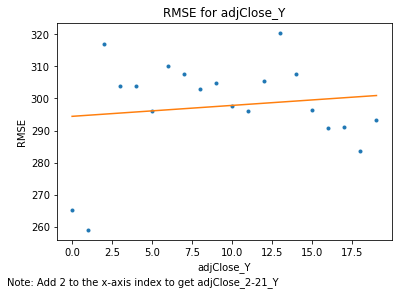

In [8]:
# Plot the RMSE for adjClose
x = np.arange(20)
y = rmse[0:20]

# Fit with polyfit
b, m = polyfit(x, y, 1)

# Add title and axis names
plt.title('RMSE for adjClose_Y')
plt.xlabel('adjClose_Y')
plt.ylabel('RMSE')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 2 to the x-axis index to get adjClose_2-21_Y',
            horizontalalignment='left')

plt.plot(x, y, '.')
plt.plot(x, m*x+b, '-')
plt.show()

In [9]:
# Evaluate MAE
mae = mean_absolute_error(y_test, ypred, multioutput='raw_values')

# For each value in mae
for i in range(1, len(mae)+1):

    # Print the MAE values for adjClose
    if i < 21:
        print("The MAE for adjClose_{}_Y = ".format(i+1), mae[i-1])

    # Print the MAE values for min day
    elif 21 <= i < 25:
        print("The MAE for {}day_min = ".format((i-20)*5), mae[i-1])

    # Print the MAE for max day
    else:
        print("The MAE for {}day_max = ".format((i-24)*5), mae[i-1])

The MAE for adjClose_2_Y =  212.55291041135789
The MAE for adjClose_3_Y =  200.82741227040688
The MAE for adjClose_4_Y =  253.75370836238065
The MAE for adjClose_5_Y =  245.56035271455843
The MAE for adjClose_6_Y =  246.3002075784405
The MAE for adjClose_7_Y =  238.65896855374177
The MAE for adjClose_8_Y =  250.4041869511207
The MAE for adjClose_9_Y =  240.7133555897077
The MAE for adjClose_10_Y =  236.330614678363
The MAE for adjClose_11_Y =  243.38383172035216
The MAE for adjClose_12_Y =  235.8544697329402
The MAE for adjClose_13_Y =  235.20438006738823
The MAE for adjClose_14_Y =  246.8675330891212
The MAE for adjClose_15_Y =  260.44723804563284
The MAE for adjClose_16_Y =  245.3717230240504
The MAE for adjClose_17_Y =  228.7978434662024
The MAE for adjClose_18_Y =  223.06577102422713
The MAE for adjClose_19_Y =  220.7156545617183
The MAE for adjClose_20_Y =  204.43056223154068
The MAE for adjClose_21_Y =  218.69350966850917
The MAE for 5day_min =  1.3464216836293539
The MAE for 10d

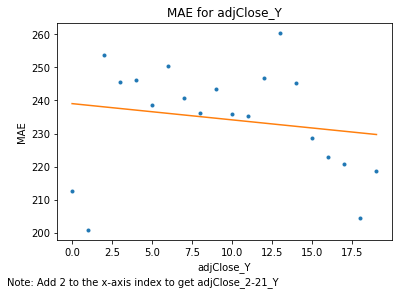

In [10]:
# Plot the MAE for adjClose
x = np.arange(20)
y = mae[0:20]

# Fit with polyfit
b, m = polyfit(x, y, 1)

# Add title and axis names
plt.title('MAE for adjClose_Y')
plt.xlabel('adjClose_Y')
plt.ylabel('MAE')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 2 to the x-axis index to get adjClose_2-21_Y',
            horizontalalignment='left')

plt.plot(x, y, '.')
plt.plot(x, m*x+b, '-')
plt.show()